In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import warnings
warnings.filterwarnings('ignore')

# Linear regression

I will start with the simplest regression. Since we are looking to make ordinal classification, I will use target 0, 0.5 and 1 and then find the optimum boundaries 0 <= a <= 0.5 and 0.5 <= b <= 1.

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score

In [3]:
def classify(x, a, b):
    if x < a:
        return 0
    elif a <= x and x < b:
        return 0.5
    else : 
        return 1

In [4]:
def trans(x):
    if x == 0:
        return int(1)
    elif x == 0.5:
        return int(2)
    elif x == 1 : 
        return int(3)

In [5]:
def eval(reg, X_test, y_test, a, b):
    predict = reg.predict(X_test)
    damages_test = pd.Series(predict.reshape(len(predict))).apply(classify, args=(a,b))
    damages_test = damages_test.apply(trans)
    y_test = y_test["damage_grade"].apply(trans)
    return f1_score(y_test, damages_test, average='micro')

Instead of gridsearching a and b, I will use bayesian optimization from skopt

In [6]:
spaceReg  = [Real(0, 0.5, name="a"),
          Real(0.5, 1, name="b")]

In [7]:
@use_named_args(spaceReg)
def objectiveReg(a, b):
    reg.fit(X_train,y_train)
    predict = reg.predict(X_train)
    damages = pd.Series(predict.reshape(len(predict))).apply(classify, args=(a,b))
    damages = damages.apply(trans)
    y = y_train["damage_grade"].apply(trans)
    return 1 - f1_score(y, damages, average='micro')

In [8]:
X_train = pd.read_csv('Datasets/CV0_train_subset_0.csv', index_col=0)
y_train= pd.read_csv('Datasets/train_labels_scaled.csv', index_col=0).loc[X_train.index]
reg = LinearRegression()
res_reg = gp_minimize(objectiveReg, spaceReg, n_calls=100, random_state=0)
1-res_reg.fun, res_reg.x[0], res_reg.x[1]

(0.7059511373064903, 0.3069034116268044, 0.7394089644672852)

Now that we have optimum boundaries for subset0, let's find out if it generalize well on other subsets.

In [9]:
score = pd.DataFrame(index=range(10), columns=['score_test', 'score_train']).fillna(0)
for i in score.index:
    X_train = pd.read_csv('Datasets/CV0_train_subset_{}.csv'.format(i), index_col=0)
    X_test = pd.read_csv('Datasets/CV0_test_subset_{}.csv'.format(i), index_col=0)
    y_train= pd.read_csv('Datasets/train_labels_scaled.csv', index_col=0).loc[X_train.index]
    y_test= pd.read_csv('Datasets/train_labels_scaled.csv', index_col=0).loc[X_test.index]
    reg = LinearRegression()
    reg.fit(X_train,y_train)
    score.loc[i,'score_train'] = eval(reg, X_train, y_train, res_reg.x[0], res_reg.x[1])
    score.loc[i, 'score_test'] = eval(reg, X_test, y_test, res_reg.x[0], res_reg.x[1])

In [10]:
score

,score_test,score_train
0,0.705602,0.705951
1,0.705756,0.705609
2,0.705718,0.705826
3,0.702034,0.706379
4,0.711934,0.705287
5,0.704605,0.706203
6,0.707636,0.705635
7,0.705948,0.705767
8,0.702840,0.706135
9,0.704770,0.706085


All scores are homogeneous therefore the generalization is good.

In [11]:
def plot_learning_curves_reg(model, n, a, b):
    X_train = pd.read_csv('Datasets/CV0_train_subset_{}.csv'.format(n), index_col=0)
    X_test = pd.read_csv('Datasets/CV0_test_subset_{}.csv'.format(n), index_col=0)
    y_train= pd.read_csv('Datasets/train_labels_scaled.csv', index_col=0).loc[X_train.index]
    y_test= pd.read_csv('Datasets/train_labels_scaled.csv', index_col=0).loc[X_test.index]
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)//1000):
        m = m*1000
        reg = model.fit(X_train[:m], y_train[:m])
        train_errors.append(eval(reg, X_train[:m], y_train[:m], a, b))
        val_errors.append(eval(reg, X_test, y_test, a, b))
        #print(str(m) + " out of " + str(len(X_train)), " train error : " + str(train_errors[-1]), 
              #" val error : " + str(val_errors[-1]))
    plt.plot(train_errors, "r-+", linewidth=2, label="train")
    plt.plot(val_errors, "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size / 1000", fontsize=14)
    plt.ylabel("F1 score", fontsize=14)

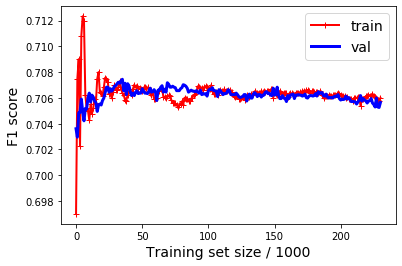

In [12]:
plot_learning_curves_reg(LinearRegression(), 0, res_reg.x[0], res_reg.x[1])

Finally, the learning curve shows that no early stopping is required here.

# ElasticNet

ElasticNet is a regression with a regularization on the loss function : we need to tune this regularization hyperparameter (l1_ratio), once again with skopt.

In [13]:
from sklearn.linear_model import ElasticNet

In [14]:
spaceEla  = [Real(.0001, .9999, name="l1_ratio"),
          Real(.0001, .9999, name="alpha")]

In [15]:
@use_named_args(spaceEla)
def objectiveEla(**params):
    elastic.set_params(**params)
    elastic.fit(X_train,y_train)
    predict = elastic.predict(X_train)
    damages = pd.Series(predict.reshape(len(predict))).apply(classify, args=(0.30,0.75))
    damages = damages.apply(trans)
    y = y_train["damage_grade"].apply(trans)
    return 1 - f1_score(y, damages, average='micro')

In [16]:
X_train = pd.read_csv('Datasets/CV0_train_subset_0.csv', index_col=0)
y_train= pd.read_csv('Datasets/train_labels_scaled.csv', index_col=0).loc[X_train.index]
elastic = ElasticNet(max_iter=1000)
res_ela = gp_minimize(objectiveEla, spaceEla, n_calls=15, random_state=0)
1-res_ela.fun, res_ela.x[0], res_ela.x[1]

(0.7056416076625783, 0.9999, 0.0001)

ElasticNet is useless here.

# SoftMax

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
spaceSoft  = [Real(.0001, 1000, name="C")]

In [19]:
@use_named_args(spaceSoft)
def objectiveSoft(**params):
    softmax.set_params(**params)
    softmax.fit(X_train,y_train)
    predict = softmax.predict(X_train)
    return 1 - f1_score(y_train, predict, average='micro')

I will try softmax with balanced class weights and without.

In [20]:
X_train = pd.read_csv('Datasets/CV0_train_subset_0.csv', index_col=0)
y_train= pd.read_csv('Datasets/train_labels_scaled.csv', index_col=0).loc[X_train.index]["damage_grade"].apply(trans)
softmax = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=2000)
res_soft = gp_minimize(objectiveSoft, spaceSoft, n_calls=20, random_state=0)
1-res_soft.fun, res_soft.x[0]

(0.7151983354183594, 0.020127528112343494)

In [21]:
X_train = pd.read_csv('Datasets/CV0_train_subset_0.csv', index_col=0)
y_train= pd.read_csv('Datasets/train_labels_scaled.csv', index_col=0).loc[X_train.index]["damage_grade"].apply(trans)
softmax = LogisticRegression(multi_class="multinomial", class_weight="balanced", solver="lbfgs", max_iter=2000)
res_soft_balanced = gp_minimize(objectiveSoft, spaceSoft, n_calls=20, random_state=0)
1-res_soft_balanced.fun, res_soft_balanced.x[0]

(0.6724574504215192, 0.020127528112343494)

So softmax without balanced class weights is the best. We will see if it generalizes well.

In [22]:
score3 = pd.DataFrame(index=range(10), columns=['score_test', 'score_train']).fillna(0)
for i in score3.index:
    X_train = pd.read_csv('Datasets/CV0_train_subset_{}.csv'.format(i), index_col=0)
    X_test = pd.read_csv('Datasets/CV0_test_subset_{}.csv'.format(i), index_col=0)
    y_train= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_train.index]["damage_grade"]
    y_test= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_test.index]["damage_grade"]
    softmax = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=2000, C=res_soft.x[0])
    softmax.fit(X_train,y_train)
    score3.loc[i,'score_train'] = f1_score(y_train, softmax.predict(X_train), average='micro')
    score3.loc[i, 'score_test'] = f1_score(y_test, softmax.predict(X_test), average='micro')

In [23]:
score3

,score_test,score_train
0,0.717460,0.715198
1,0.714850,0.715551
2,0.714236,0.715597
3,0.711742,0.715987
4,0.719839,0.714963
5,0.712778,0.715995
6,0.718918,0.715132
7,0.715963,0.715495
8,0.714543,0.715588
9,0.714324,0.715670


Generalization of this model is very good.

In [24]:
def plot_learning_curves_clas(model, n):
    X_train = pd.read_csv('Datasets/CV0_train_subset_{}.csv'.format(n), index_col=0)
    X_test = pd.read_csv('Datasets/CV0_test_subset_{}.csv'.format(n), index_col=0)
    y_train= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_train.index]["damage_grade"]
    y_test= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_test.index]["damage_grade"]
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)//1000):
        m = m*1000
        model.fit(X_train[:m], y_train[:m])
        train_errors.append(f1_score(y_train[:m], model.predict(X_train)[:m], average='micro'))
        val_errors.append(f1_score(y_test, model.predict(X_test), average='micro'))
    plt.plot(train_errors, "r-+", linewidth=2, label="train")
    plt.plot(val_errors, "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size / 1000", fontsize=14)
    plt.ylabel("F1 score", fontsize=14)

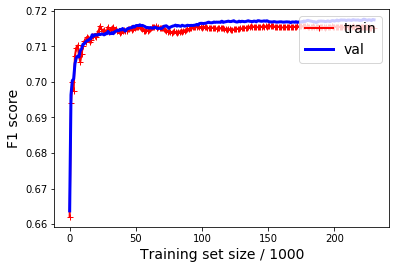

In [25]:
plot_learning_curves_clas(LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=2000, C=res_soft.x[0]), 0)

No need for an early stopping here.

# Polynomial regression w/ mini batch GD

I can not run the classic Pipeline for Polynomial regression because my laptop lacks memory to compute the polynomial data augmentation.
So I chose to train the regression by mini batch gradient descent and to provide a method to compute f1 score by sclicing the dataset in order to lower memory used.
Also, I do Polynomial regression with interaction_only=True because most of my features are one-hot encoded, so it don't make sense to square them. Instead, I will hardcoded the square of non OHE features. 

In [26]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import confusion_matrix

In [27]:
# This function computes the data augmentation to degree 2 for the given dataset
def degre2(X):
    poly_features = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
    X_1 = poly_features.fit_transform(X)
    X_2 = np.array(X)[:,:5]**2
    return np.concatenate((X_1, X_2),axis=1)

In [28]:
# This function computes the data augmentation to degree 3 for the given dataset
def degre3(X):
    poly_features3 = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
    X_1 = poly_features3.fit_transform(X)
    X_2 = np.array(X)[:,:5]**2
    X_3 = np.array(X)[:,:5]**3
    return np.concatenate((X_1, X_2, X_3),axis=1)

In [29]:
# This function computes the F1 score by slicing the given datasets to reduce memory use
def split_and_score(X_test, y_test, w, poly_features, a, b):
    FP, FN, TP = 0, 0, 0
    for i in range(max(len(X_test)//4096,1)):
        X = X_test.iloc[i*4096:min((i+1)*4096,len(X_test)),:]
        X = poly_features.transform(X)
        y = y_test.iloc[i*4096:min((i+1)*4096,len(X_test))]
        y = y.apply(trans)
        predicted = np.dot(X,w).reshape(len(y))
        predicted = pd.Series(predicted).apply(classify, args=(a,b))
        predicted = predicted.apply(trans)
        cm = confusion_matrix(y, predicted)
        FP += cm.sum(axis=0) - np.diag(cm)  
        TP += np.diag(cm)
    FP, TP = FP.sum(), TP.sum()
    return TP/(TP+FP)

In [30]:
# This function computes the whole pipeline. In order to reduce computation time, score_test and score_test will be
# evaluated every 512 batches (for batch_size=32).
def model_poly(X_train, y_train, X_test, y_test, epochs, batch_size, a, b, learning_schedule, t0, t1):
    process = FunctionTransformer(func=degre2, accept_sparse=True, inverse_func=None, validate=False)
    example = process.fit_transform(X_train.iloc[:1,:])
    w = np.random.normal(size=(np.shape(example)[1],1))
    t = 0
    score_train, score_test = [], []
    w_up = [w]
    for e in range(epochs):
        shuffled_indices = np.random.permutation(len(X_train))
        X_train_shuffled = X_train.iloc[shuffled_indices,:]
        y_train_shuffled = y_train.iloc[shuffled_indices]
        for i in range(0, len(X_train), batch_size):
            t += 1
            xi = X_train_shuffled.iloc[i:i+batch_size,:]
            xi = process.transform(xi)
            yi = y_train_shuffled.iloc[i:i+batch_size]
            gradients = (2/batch_size) * xi.T.dot(xi.dot(w).reshape(len(yi)) - yi)
            eta = learning_schedule(t, t0, t1)
            gradients = gradients.reshape(np.shape(w))
            w = w - eta * gradients
            if i%16384 ==0 :
                w_up += [w]
                stest = split_and_score(X_test, y_test, w, process, a, b)
                score_test += [stest]
                print(e, i, stest)
            if(len(score_test)>3 and score_test[-1] == score_test[-2] and score_test[-2] == score_test[-3]):
                return score_train, score_test, w_up
    return score_train, score_test, w_up

Degre = 2

In [31]:
X_train = pd.read_csv('Datasets/CV0_train_subset_0.csv', index_col=0)
X_test = pd.read_csv('Datasets/CV0_test_subset_0.csv', index_col=0)
y_train= pd.read_csv('Datasets/train_labels_scaled.csv', index_col=0).loc[X_train.index]["damage_grade"]
y_test= pd.read_csv('Datasets/train_labels_scaled.csv', index_col=0).loc[X_test.index]["damage_grade"]

In [32]:
a = 0.3
b = 0.75

We first need to find the best start for the learning schedule, so I will search it only with one epoch.

In [33]:
spacePoly  = [Integer(1, 100, name="t0")]

In [34]:
def learning_schedule1(t, t0, t1):
    return t0 / (t + t1)

In [35]:
@use_named_args(spacePoly)
def objectivePoly(t0):
    score_train, score_test, w = model_poly(X_train, y_train, X_test, y_test, 1, 32, a, b, learning_schedule1, t0, 1000)
    return 1 - max(score_test)

In [36]:
res_poly = gp_minimize(objectivePoly, spacePoly, n_calls=15, random_state=0)
1-res_poly.fun, res_poly.x[0]

0 0 0.3009033203125
0 16384 0.3363850911458333
0 32768 0.2904866536458333
0 49152 0.2739664713541667
0 65536 0.203857421875
0 81920 0.22562662760416666
0 98304 0.23193359375
0 114688 0.24690755208333334
0 131072 0.20804850260416666
0 147456 0.1748046875
0 163840 0.21866861979166666
0 180224 0.2015380859375
0 196608 0.19966634114583334
0 212992 0.23588053385416666
0 229376 0.22900390625
0 0 0.1375732421875
0 16384 0.09696451822916667
0 32768 0.3363850911458333
0 49152 0.3363850911458333
0 65536 0.3363850911458333
0 0 0.08927408854166667
0 16384 0.09696451822916667
0 32768 0.3363850911458333
0 49152 0.3363850911458333
0 65536 0.3363850911458333
0 0 0.336669921875
0 16384 0.3363850911458333
0 32768 0.3363850911458333
0 49152 0.3363850911458333
0 0 0.3523763020833333
0 16384 0.3363850911458333
0 32768 0.2393798828125
0 49152 0.212890625
0 65536 0.184814453125
0 81920 0.23075358072916666
0 98304 0.20361328125
0 114688 0.2470703125
0 131072 0.2080078125
0 147456 0.2403564453125
0 163840 0.23

(0.5142415364583334, 30)

Now that we have the best start, I will try 3 different decay fashions with 25 epochs (shown on the plot below)

In [37]:
def learning_schedule2(t, t0, t1):
    return (t0 / (t+t1))*(1-0.9*t/(len(X_train)//32*25))

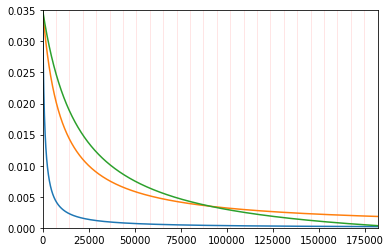

In [38]:
X = range(0, len(X_train)//32*25)
y1 = [learning_schedule1(i, 35, 1000) for i in X]
y2 = [learning_schedule1(i, 350, 10000) for i in X]
y3 = [learning_schedule2(i, 700, 20000) for i in X]
for j in range(1, 25):
    plt.axvline(x=len(X_train)*j/32, color="r", alpha=0.2, linewidth=0.5)
plt.ylim(0,0.035)
plt.xlim(0,len(X_train)//32*25)
plt.plot(X,y1)
plt.plot(X,y2)
plt.plot(X,y3)

In [39]:
score_train1, score_test1, w_up1 = model_poly(X_train, y_train, X_test, y_test, 25, 32, a, b, 
                                              learning_schedule1, res_poly.x[0], 1000)

0 0 0.15384928385416666
0 16384 0.3763834635416667
0 32768 0.4084879557291667
0 49152 0.4274088541666667
0 65536 0.4357503255208333
0 81920 0.4426676432291667
0 98304 0.4498697916666667
0 114688 0.4654947916666667
0 131072 0.4635009765625
0 147456 0.4565836588541667
0 163840 0.46923828125
0 180224 0.4572347005208333
0 196608 0.4757486979166667
0 212992 0.4773763020833333
0 229376 0.4796142578125
1 0 0.48046875
1 16384 0.4789632161458333
1 32768 0.482177734375
1 49152 0.4755045572916667
1 65536 0.4890950520833333
1 81920 0.4897054036458333
1 98304 0.4877522786458333
1 114688 0.4884440104166667
1 131072 0.4775797526041667
1 147456 0.4792073567708333
1 163840 0.4948323567708333
1 180224 0.4866129557291667
1 196608 0.4963785807291667
1 212992 0.5003662109375
1 229376 0.5013020833333334
2 0 0.4972737630208333
2 16384 0.5010579427083334
2 32768 0.4986165364583333
2 49152 0.5017903645833334
2 65536 0.5020345052083334
2 81920 0.5007731119791666
2 98304 0.5052897135416666
2 114688 0.50142415364

20 147456 0.5475260416666666
20 163840 0.5475260416666666
20 180224 0.547119140625
20 196608 0.55029296875
20 212992 0.5487874348958334
20 229376 0.5475667317708334
21 0 0.5470784505208334
21 16384 0.5482177734375
21 32768 0.5462646484375
21 49152 0.5480143229166666
21 65536 0.5488688151041666
21 81920 0.5504964192708334
21 98304 0.5471598307291666
21 114688 0.5487874348958334
21 131072 0.5480143229166666
21 147456 0.5499674479166666
21 163840 0.5478922526041666
21 180224 0.5453287760416666
21 196608 0.5501302083333334
21 212992 0.5499674479166666
21 229376 0.5491943359375
22 0 0.550537109375
22 16384 0.5477701822916666
22 32768 0.5506184895833334
22 49152 0.5511067708333334
22 65536 0.5480550130208334
22 81920 0.5508219401041666
22 98304 0.5472412109375
22 114688 0.5498453776041666
22 131072 0.5502522786458334
22 147456 0.55029296875
22 163840 0.5476888020833334
22 180224 0.5503336588541666
22 196608 0.5485026041666666
22 212992 0.5500895182291666
22 229376 0.5501302083333334
23 0 0.5

In [40]:
score_train2, score_test2, w_up2 = model_poly(X_train, y_train, X_test, y_test, 25, 32, a, b, 
                                              learning_schedule1, res_poly.x[0]*10, 10000)

0 0 0.3453369140625
0 16384 0.36767578125
0 32768 0.383544921875
0 49152 0.4325358072916667
0 65536 0.4669596354166667
0 81920 0.456298828125
0 98304 0.49853515625
0 114688 0.5083821614583334
0 131072 0.5229085286458334
0 147456 0.5230305989583334
0 163840 0.4903971354166667
0 180224 0.5455322265625
0 196608 0.5389404296875
0 212992 0.5274658203125
0 229376 0.5560709635416666
1 0 0.5362548828125
1 16384 0.5691731770833334
1 32768 0.5386962890625
1 49152 0.5672607421875
1 65536 0.5716145833333334
1 81920 0.5902913411458334
1 98304 0.5674641927083334
1 114688 0.5853678385416666
1 131072 0.5894775390625
1 147456 0.5900065104166666
1 163840 0.5838216145833334
1 180224 0.5906575520833334
1 196608 0.5959065755208334
1 212992 0.5959879557291666
1 229376 0.5999348958333334
2 0 0.6055908203125
2 16384 0.5965983072916666
2 32768 0.6041666666666666
2 49152 0.6013590494791666
2 65536 0.6063639322916666
2 81920 0.6114501953125
2 98304 0.6082356770833334
2 114688 0.614013671875
2 131072 0.6059570312

20 180224 0.6707763671875
20 196608 0.6723225911458334
20 212992 0.674560546875
20 229376 0.6702473958333334
21 0 0.6704508463541666
21 16384 0.6713053385416666
21 32768 0.6695963541666666
21 49152 0.6705729166666666
21 65536 0.6731770833333334
21 81920 0.6721598307291666
21 98304 0.672607421875
21 114688 0.6744791666666666
21 131072 0.6737467447916666
21 147456 0.674072265625
21 163840 0.673095703125
21 180224 0.672607421875
21 196608 0.6737467447916666
21 212992 0.67333984375
21 229376 0.6725667317708334
22 0 0.6739908854166666
22 16384 0.6735026041666666
22 32768 0.6728515625
22 49152 0.6741129557291666
22 65536 0.6723225911458334
22 81920 0.6733805338541666
22 98304 0.6724446614583334
22 114688 0.673583984375
22 131072 0.6715087890625
22 147456 0.6746419270833334
22 163840 0.6742350260416666
22 180224 0.6745198567708334
22 196608 0.6720784505208334
22 212992 0.6726481119791666
22 229376 0.6710611979166666
23 0 0.672607421875
23 16384 0.671630859375
23 32768 0.675048828125
23 49152 

In [41]:
score_train3, score_test3, w_up3 = model_poly(X_train, y_train, X_test, y_test, 25, 32, a, b, 
                                              learning_schedule2, res_poly.x[0]*20, 20000)

0 0 0.191162109375
0 16384 0.3193766276041667
0 32768 0.3045654296875
0 49152 0.2623697916666667
0 65536 0.4694417317708333
0 81920 0.463134765625
0 98304 0.2686360677083333
0 114688 0.4921061197916667
0 131072 0.5454915364583334
0 147456 0.5441080729166666
0 163840 0.5531819661458334
0 180224 0.5211995442708334
0 196608 0.52685546875
0 212992 0.5646565755208334
0 229376 0.4719645182291667
1 0 0.5797119140625
1 16384 0.5856119791666666
1 32768 0.5673014322916666
1 49152 0.585205078125
1 65536 0.5367838541666666
1 81920 0.59375
1 98304 0.6011962890625
1 114688 0.6064046223958334
1 131072 0.5892740885416666
1 147456 0.6092122395833334
1 163840 0.5987141927083334
1 180224 0.6110026041666666
1 196608 0.6107991536458334
1 212992 0.6111653645833334
1 229376 0.6116536458333334
2 0 0.6142171223958334
2 16384 0.618408203125
2 32768 0.6066487630208334
2 49152 0.6133219401041666
2 65536 0.6175944010416666
2 81920 0.603515625
2 98304 0.6195882161458334
2 114688 0.6270345052083334
2 131072 0.621134

20 163840 0.6736653645833334
20 180224 0.6756591796875
20 196608 0.6752115885416666
20 212992 0.6745198567708334
20 229376 0.6744791666666666
21 0 0.675048828125
21 16384 0.6754964192708334
21 32768 0.6728108723958334
21 49152 0.6758626302083334
21 65536 0.6754150390625
21 81920 0.67431640625
21 98304 0.6758219401041666
21 114688 0.675537109375
21 131072 0.6741943359375
21 147456 0.675048828125
21 163840 0.6753743489583334
21 180224 0.6759440104166666
21 196608 0.6737467447916666
21 212992 0.6759440104166666
21 229376 0.6736246744791666
22 0 0.6735026041666666
22 16384 0.67333984375
22 32768 0.6767171223958334
22 49152 0.67529296875
22 65536 0.6754150390625
22 81920 0.6749267578125
22 98304 0.6734212239583334
22 114688 0.6747639973958334
22 131072 0.6746826171875
22 147456 0.675537109375
22 163840 0.6747639973958334
22 180224 0.6746012369791666
22 196608 0.6761067708333334
22 212992 0.6752522786458334
22 229376 0.6736246744791666
23 0 0.6749674479166666
23 16384 0.6741943359375
23 3276

2 and 3 are quite well, but maybe they can do better with a lower decay.

In [42]:
score_train2, score_test2, w_up2 = model_poly(X_train, y_train, X_test, y_test, 25, 32, a, b, 
                                              learning_schedule1, res_poly.x[0]*100, 100000)

0 0 0.1778564453125
0 16384 0.3085123697916667
0 32768 0.4148356119791667
0 49152 0.4619954427083333
0 65536 0.3619384765625
0 81920 0.3915608723958333
0 98304 0.444091796875
0 114688 0.447265625
0 131072 0.4906412760416667
0 147456 0.5282389322916666
0 163840 0.542236328125
0 180224 0.52685546875
0 196608 0.5343017578125
0 212992 0.3261311848958333
0 229376 0.4974365234375
1 0 0.389404296875
1 16384 0.5640462239583334
1 32768 0.4839680989583333
1 49152 0.4108072916666667
1 65536 0.56396484375
1 81920 0.5316975911458334
1 98304 0.4957275390625
1 114688 0.5834147135416666
1 131072 0.5292561848958334
1 147456 0.4691975911458333
1 163840 0.43310546875
1 180224 0.5948893229166666
1 196608 0.4910074869791667
1 212992 0.6106363932291666
1 229376 0.572265625
2 0 0.5991617838541666
2 16384 0.6065266927083334
2 32768 0.6150716145833334
2 49152 0.611572265625
2 65536 0.5426025390625
2 81920 0.5757242838541666
2 98304 0.6212158203125
2 114688 0.6048990885416666
2 131072 0.62744140625
2 147456 0.6

20 196608 0.6890055338541666
20 212992 0.7024332682291666
20 229376 0.6902669270833334
21 0 0.7004801432291666
21 16384 0.7010091145833334
21 32768 0.6952718098958334
21 49152 0.6992594401041666
21 65536 0.7020670572916666
21 81920 0.698486328125
21 98304 0.7010498046875
21 114688 0.6991373697916666
21 131072 0.6966959635416666
21 147456 0.6966959635416666
21 163840 0.6985677083333334
21 180224 0.6945393880208334
21 196608 0.6987711588541666
21 212992 0.6914469401041666
21 229376 0.6988525390625
22 0 0.7032470703125
22 16384 0.7029622395833334
22 32768 0.6998697916666666
22 49152 0.7005615234375
22 65536 0.6861979166666666
22 81920 0.7012532552083334
22 98304 0.6891276041666666
22 114688 0.7008870442708334
22 131072 0.6908365885416666
22 147456 0.701904296875
22 163840 0.6993408203125
22 180224 0.7013753255208334
22 196608 0.6957194010416666
22 212992 0.6986083984375
22 229376 0.69921875
23 0 0.703125
23 16384 0.7000732421875
23 32768 0.7017008463541666
23 49152 0.7030436197916666
23 6

In [43]:
score_train3, score_test3, w_up3 = model_poly(X_train, y_train, X_test, y_test, 25, 32, a, b, 
                                              learning_schedule2, res_poly.x[0]*200, 200000)

0 0 0.24287923177083334
0 16384 0.22660319010416666
0 32768 0.3764241536458333
0 49152 0.4613850911458333
0 65536 0.4923909505208333
0 81920 0.35888671875
0 98304 0.398193359375
0 114688 0.43798828125
0 131072 0.3445231119791667
0 147456 0.5281982421875
0 163840 0.547119140625
0 180224 0.4970296223958333
0 196608 0.5671793619791666
0 212992 0.5801188151041666
0 229376 0.5671793619791666
1 0 0.5011800130208334
1 16384 0.5312906901041666
1 32768 0.5776774088541666
1 49152 0.4535319010416667
1 65536 0.6016438802083334
1 81920 0.58740234375
1 98304 0.57568359375
1 114688 0.6005045572916666
1 131072 0.5953776041666666
1 147456 0.61767578125
1 163840 0.6006673177083334
1 180224 0.6142171223958334
1 196608 0.6265462239583334
1 212992 0.550048828125
1 229376 0.5308024088541666
2 0 0.5833740234375
2 16384 0.6134440104166666
2 32768 0.5953776041666666
2 49152 0.6324869791666666
2 65536 0.5436604817708334
2 81920 0.6263427734375
2 98304 0.6386311848958334
2 114688 0.6149088541666666
2 131072 0.64

20 131072 0.7001546223958334
20 147456 0.6993408203125
20 163840 0.7008463541666666
20 180224 0.7000732421875
20 196608 0.7004801432291666
20 212992 0.6999918619791666
20 229376 0.7000732421875
21 0 0.698974609375
21 16384 0.7008463541666666
21 32768 0.7000732421875
21 49152 0.6999918619791666
21 65536 0.7001546223958334
21 81920 0.7001953125
21 98304 0.7020263671875
21 114688 0.699462890625
21 131072 0.7003580729166666
21 147456 0.6986490885416666
21 163840 0.6990966796875
21 180224 0.6980794270833334
21 196608 0.7005615234375
21 212992 0.7000325520833334
21 229376 0.7001953125
22 0 0.7015380859375
22 16384 0.6990152994791666
22 32768 0.7001546223958334
22 49152 0.69873046875
22 65536 0.701416015625
22 81920 0.7014973958333334
22 98304 0.7012532552083334
22 114688 0.7008056640625
22 131072 0.7013753255208334
22 147456 0.7010904947916666
22 163840 0.7006022135416666
22 180224 0.697021484375
22 196608 0.6997884114583334
22 212992 0.7006429036458334
22 229376 0.6985270182291666
23 0 0.70

0.705 seems to be our glass-ceiling score here... nevertheless, I don't want to spend computation time for a model I don't expect to be the best.